In [1]:
import pandas as pd
import nltk
import os
import re
import matplotlib.pyplot as plt
import statistics
import PyPDF2 as pdf
import seaborn as sns
import random
import string

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from pprint import pprint

pd.set_option('display.max_rows', None)

data_path = '../Data'

### Combining Data

In [2]:
def dir_pdf_to_text(file_path, doc_read_counter = True):
    '''
    Uses PyPDF2
    Function only takes in the directory of a folder anc converts all PDF files to text
    '''
    files = os.listdir(file_path)
    pdf_ls = [i for i in files if i.endswith('.pdf')]

    text_dic = {'No': [],
                'PDF_title': [],
                'Text': [],
                'Page_length': [],
                'Text_length': []
               }

    for idx, file in enumerate(pdf_ls):
        max_files = len(pdf_ls)
        with open(os.path.join(file_path, file), 'rb') as pdf_file:
            # Create a PDF reader object
            reader = pdf.PdfReader(pdf_file)

            # Get the total number of pages in the PDF document
            total_pages = len(reader.pages)

            text = []
            text_counter = 0
            # Loop through all the pages and extract the text
            for page_num in range(total_pages):
                # Get the page object
                page_obj = reader.pages[page_num]

                # Extract the text from the page
                page_text = page_obj.extract_text ()
                text_counter +=len(page_text)
                end_of_page = '=' * 30 + ' End of Page '+ str(page_num+1) + ' '+ '=' * 30

                # Append pages of the same PDF together
                text.append(page_text)
                text.append(end_of_page)

            if doc_read_counter:
                print(f'# PDF read: {idx+1} | # PDF remaining: {max_files - idx - 1} | Total # PDF to be read: {max_files}')

            # Append diff PDFs together
            text_dic['No'].append(idx+1)
            text_dic['PDF_title'].append(file)
            text_dic['Text'].append('\n\n'.join(text))
            text_dic['Page_length'].append(total_pages)
            text_dic['Text_length'].append(text_counter)
    return pd.DataFrame(text_dic)


#### PDF

In [3]:
# Extract from PDF
pdf_dir = os.path.join(data_path, 'AI Papers')

pdf_df_raw = dir_pdf_to_text(pdf_dir)
pdf_df_processed = pdf_df_raw.copy()

# Remove redundant columns
pdf_df_processed = pdf_df_processed[['PDF_title', 'Text']]
pdf_df_processed.rename(columns={'PDF_title': 'Title', 'Text':'Contents'}, inplace = True)
pdf_df_processed['Source'] = 'PDF'

# PDF read: 1 | # PDF remaining: 9 | Total # PDF to be read: 10
# PDF read: 2 | # PDF remaining: 8 | Total # PDF to be read: 10
# PDF read: 3 | # PDF remaining: 7 | Total # PDF to be read: 10
# PDF read: 4 | # PDF remaining: 6 | Total # PDF to be read: 10
# PDF read: 5 | # PDF remaining: 5 | Total # PDF to be read: 10
# PDF read: 6 | # PDF remaining: 4 | Total # PDF to be read: 10
# PDF read: 7 | # PDF remaining: 3 | Total # PDF to be read: 10
# PDF read: 8 | # PDF remaining: 2 | Total # PDF to be read: 10
# PDF read: 9 | # PDF remaining: 1 | Total # PDF to be read: 10
# PDF read: 10 | # PDF remaining: 0 | Total # PDF to be read: 10


#### Google news

In [4]:
google_news_df_raw = pd.read_excel(os.path.join(data_path, 'Google News Data.xlsx'))

google_news_processed = google_news_df_raw.copy()

# Remove redundant columns
google_news_processed = google_news_processed[['Title', 'Article']]
google_news_processed.rename(columns={ 'Article':'Contents'}, inplace = True)
google_news_processed['Source'] = 'Google_News'

#### Reddit

In [5]:
reddit_df_raw = pd.read_excel(os.path.join(data_path, 'Reddit Data.xlsx'))

reddit_df_processed = reddit_df_raw.copy()

# Remove redundant columns
reddit_df_processed = reddit_df_processed[['Title', 'Article']]
reddit_df_processed.rename(columns={ 'Article':'Contents'}, inplace = True)
reddit_df_processed['Source'] = 'Reddit'

### Combining dataset from 3 different domains

- Each document is defined as an article/PDF/reddit post

In [6]:
df_raw = pd.concat([google_news_processed, reddit_df_processed, pdf_df_processed]).reset_index(drop=True)

In [9]:
# df_raw.to_csv('df_raw.csv', index=False)

# Run from here onwards

In [10]:
# df_raw = pd.read_csv('df_raw.csv')

### Tokenization

Tokenize all documents in each domain using a selected library (e.g., NLTK) and observe the tokens obtained. Discuss your observations from the following perspectives. Has the tokenizer correctly recognized the domain specific tokens? Use examples to illustrate what the expected tokens are, and what are not, particularly on the domain specific terms.

- NLKT tokenizer tokenizes words by a mixture of blank space and punctuations. This function uses the Punkt tokenizer for tokenizing words. Punkt is a pre-trained unsupervised machine learning model for tokenizing sentences. It comes with pre-trained models for some languages, including English.

- Some of the words are wrongly tokenized
    1. Google News
        - Numbers with commas in the middle are correctly tokenized as the same word e.g. 3,700 -> '3,700'
        - Words with - are tokenized correctly into single tokens. e.g. co-founder -> 'co-founder'
        - Words with apostrophe should not be tokenized. E.g. sector's -> 'tech', 'sector', "'s"
            - Words with ' should not be split
        - Names should be tokenized as a single token E.g Web Summit -> 'Web', 'Summit', Paddy Cosgrave -> 'Paddy', 'Cosgrave'
            - Consecutive words with first alphabets in caps, excluding those at the start of a sentence, should not be split
        - Dates should not be tokenized e.g. Oct 7 -> 'Oct', '7'
            - Up to 2 sets of numbers to left and right of each month (long and short form) should be group together
    2. Reddit
        -  Team names should be tokenized as a single token e.g.G2 Esports -> 'G2', 'Esports'
    3. PDF
        - Figure X should be tokenized together  
            - Figure X, followed by a number (regardless of .) should be groupped together.

In [7]:
# Tokenize
df_raw['token_words'] = df_raw['Contents'].apply(word_tokenize)

In [8]:
df_raw.Source.unique()

array(['Google_News', 'Reddit', 'PDF'], dtype=object)

In [9]:
print(df_raw.loc[df_raw.Source == 'Reddit'].reset_index(drop = True).Contents[4])

Highlight Results

The introduction of the Swiss stage gives Western teams a 33% relative increase in the estimated chance of winning Worlds versus a Swissless simulation (up from 1.5% to 2.1%), and a further relative improvement of a Western team making it to finals by approximately 50% (from 6.8% to 10.24%). We also observe that the Swiss stage has improved the chances of a Western team making it through to the knockout stage, with the odds of at least one Western team making it out improving from 84.5% to 96.7%.
Introduction

Hiya all, I began putting together a Stochastic Simulation to explore this, and slowly it developed into a full-fledged side-project that I worked on occasionally alongside my PhD. Started LoL in Season 2 and have been consuming some flavour of Lol Esports since around then (the first match I watched was the CLG-EU vs M5 70min). I have never posted on Reddit before, but I wanted to share my work properly (even if between moving home and getting internet it's no

In [10]:
'|'.join(df_raw.loc[df_raw.Source == 'Reddit'].reset_index(drop = True).token_words[4])

"Highlight|Results|The|introduction|of|the|Swiss|stage|gives|Western|teams|a|33|%|relative|increase|in|the|estimated|chance|of|winning|Worlds|versus|a|Swissless|simulation|(|up|from|1.5|%|to|2.1|%|)|,|and|a|further|relative|improvement|of|a|Western|team|making|it|to|finals|by|approximately|50|%|(|from|6.8|%|to|10.24|%|)|.|We|also|observe|that|the|Swiss|stage|has|improved|the|chances|of|a|Western|team|making|it|through|to|the|knockout|stage|,|with|the|odds|of|at|least|one|Western|team|making|it|out|improving|from|84.5|%|to|96.7|%|.|Introduction|Hiya|all|,|I|began|putting|together|a|Stochastic|Simulation|to|explore|this|,|and|slowly|it|developed|into|a|full-fledged|side-project|that|I|worked|on|occasionally|alongside|my|PhD|.|Started|LoL|in|Season|2|and|have|been|consuming|some|flavour|of|Lol|Esports|since|around|then|(|the|first|match|I|watched|was|the|CLG-EU|vs|M5|70min|)|.|I|have|never|posted|on|Reddit|before|,|but|I|wanted|to|share|my|work|properly|(|even|if|between|moving|home|and|g

In [11]:
print(df_raw.loc[df_raw.Source == 'PDF'].reset_index(drop = True).token_words[0])

['Provided', 'proper', 'attribution', 'is', 'provided', ',', 'Google', 'hereby', 'grants', 'permission', 'to', 'reproduce', 'the', 'tables', 'and', 'figures', 'in', 'this', 'paper', 'solely', 'for', 'use', 'in', 'journalistic', 'or', 'scholarly', 'works', '.', 'Attention', 'Is', 'All', 'You', 'Need', 'Ashish', 'Vaswani∗', 'Google', 'Brain', 'avaswani', '@', 'google.comNoam', 'Shazeer∗', 'Google', 'Brain', 'noam', '@', 'google.comNiki', 'Parmar∗', 'Google', 'Research', 'nikip', '@', 'google.comJakob', 'Uszkoreit∗', 'Google', 'Research', 'usz', '@', 'google.com', 'Llion', 'Jones∗', 'Google', 'Research', 'llion', '@', 'google.comAidan', 'N.', 'Gomez∗', '†', 'University', 'of', 'Toronto', 'aidan', '@', 'cs.toronto.eduŁukasz', 'Kaiser∗', 'Google', 'Brain', 'lukaszkaiser', '@', 'google.com', 'Illia', 'Polosukhin∗', '‡', 'illia.polosukhin', '@', 'gmail.com', 'Abstract', 'The', 'dominant', 'sequence', 'transduction', 'models', 'are', 'based', 'on', 'complex', 'recurrent', 'or', 'convolutional'

### Stemming

Perform stemming and compare the token distributions before and after the stemming (you may choose any stemming algorithm implemented in any toolkit).

You may compare:
    - The number of distinct tokens
    - The length distribution of the token (The length distribution can be compared in a plot: the x-axis is the length of a token in number of characters, and the y-axis is the number of tokens of each length)
    
Discuss your findings
    - Number of distinct tokens significantly reduced from 16,856 to 12,855 (~24% reduction)
    - Words between the length of 10 to 15 experience the highest number of frequency reduction (refer to table)
        - Most of the more common words lie between this length
        - Words > length of 20 tend to be rare words/dirty data which should be removed during data cleaning phase

In [12]:
# Remove tokens with only punctuations
def no_punc(tokens):
    punctuation_set = set(string.punctuation)
    filtered_tokens = [token for token in tokens if not all(char in punctuation_set for char in token)]
    return filtered_tokens

df_raw['no_punc'] = df_raw.token_words.apply(no_punc)

In [13]:
# Stemming
stemmer = PorterStemmer()
df_raw['stemmed_text'] = df_raw.no_punc.apply(lambda x: [stemmer.stem(token) for token in x])

In [14]:
# Comparing before and after stemming:
before_stemming_col = 'no_punc'

stem_comparison = pd.DataFrame({'before_stem': [item for sublist in df_raw[before_stemming_col] for item in sublist]})
stem_comparison['after_stem'] = stem_comparison.before_stem.apply(stemmer.stem)
stem_comparison.drop_duplicates(inplace = True)

#### Distinct tokens before and after stemming 

In [15]:
# Multiple words are stemmed into the same word
print(f' Number of distinct token before stemming: {stem_comparison.before_stem.nunique()}')
print(f' Number of distinct token after stemming: {stem_comparison.after_stem.nunique()}')

 Number of distinct token before stemming: 16856
 Number of distinct token after stemming: 12855


#### Plotting word distribution

In [16]:
stem_comparison['len_before_stem'] = stem_comparison.before_stem.apply(len)
stem_comparison['len_after_stem'] = stem_comparison.after_stem.apply(len)

In [17]:
stem_comparison.loc[stem_comparison.len_after_stem>30].sort_values(['len_before_stem']).head()

,before_stem,after_stem,len_before_stem,len_after_stem
86016,//aclanthology.org/2022.wmt-1.2,//aclanthology.org/2022.wmt-1.2,31,31
104688,training2530354045505560ImageNet,training2530354045505560imagenet,32,32
53540,Re-computationStreamingLLMMemory,re-computationstreamingllmmemori,32,32
53527,040080012001600256512102420484096,040080012001600256512102420484096,33,33
93714,Length50100150200250300Throughput,length50100150200250300throughput,33,33


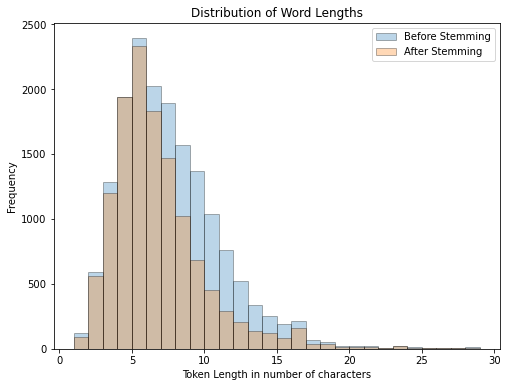

In [18]:
before_stemmming = stem_comparison[['before_stem','len_before_stem']].drop_duplicates()
after_stemmming = stem_comparison[['after_stem','len_after_stem']].drop_duplicates()

plt.figure(figsize=(8, 6))

plt.hist(before_stemmming['len_before_stem']
         , bins=range(min(before_stemmming['len_before_stem']), 30, 1)
         , edgecolor='black'
         , alpha = 0.3
         , label = 'Before Stemming')

plt.hist(after_stemmming['len_after_stem']
         , bins=range(min(after_stemmming['len_after_stem']), 30, 1)
         , edgecolor='black'
         , alpha = 0.3
         , label = 'After Stemming')

plt.xlabel('Token Length in number of characters')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')
plt.legend()

In [19]:
# Check % reduction of words by character length

len_after_stem_df = pd.DataFrame(after_stemmming.len_after_stem.value_counts())\
    .reset_index().rename(columns={'index': 'Token_len', 'len_after_stem': 'Count_after_stem'})

len_before_stem_df = pd.DataFrame(before_stemmming.len_before_stem.value_counts())\
    .reset_index().rename(columns={'index': 'Token_len', 'len_before_stem': 'Count_before_stem'})

len_comparison_df = pd.merge(len_before_stem_df, len_after_stem_df, how = 'left', on = 'Token_len')
len_comparison_df.sort_values('Token_len', inplace = True)

len_comparison_df['change'] = (len_comparison_df.Count_before_stem - len_comparison_df.Count_after_stem)

len_comparison_df['per_change'] = (len_comparison_df.Count_before_stem - len_comparison_df.Count_after_stem)\
    /len_comparison_df.Count_before_stem * 100

In [20]:
len_comparison_df.sort_values('per_change', ascending = False).head(10)

,Token_len,Count_before_stem,Count_after_stem,change,per_change
38,52,3,1.0,2.0,66.666667
37,31,3,1.0,2.0,66.666667
36,37,3,1.0,2.0,66.666667
8,11,764,288.0,476.0,62.303665
10,12,522,208.0,314.0,60.153257
11,13,335,139.0,196.0,58.507463
14,15,189,83.0,106.0,56.084656
7,10,1038,456.0,582.0,56.069364
18,19,25,12.0,13.0,52.000000
42,42,2,1.0,1.0,50.000000


Text(0.5, 1.0, 'Change in token length (absolute number)')

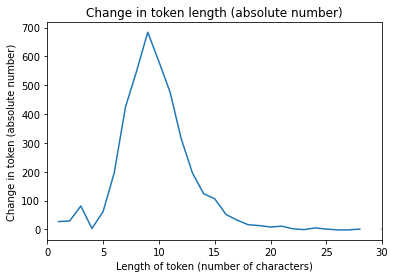

In [21]:
plt.plot(len_comparison_df.Token_len, len_comparison_df.change)

plt.xlim(0,30)
plt.xlabel('Length of token (number of characters)')
plt.ylabel('Change in token (absolute number)')
plt.title('Change in token length (absolute number)')

Text(0.5, 1.0, 'Change in token length (% change)')

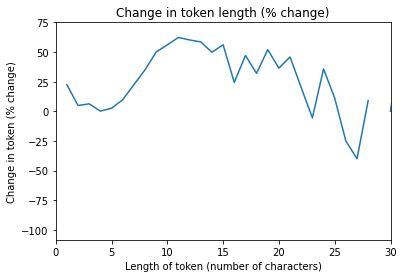

In [22]:
plt.plot(len_comparison_df.Token_len, len_comparison_df.per_change)

plt.xlim(0,30)
plt.xlabel('Length of token (number of characters)')
plt.ylabel('Change in token (% change)')
plt.title('Change in token length (% change)')

### Sentence segmentation

Perform sentence segmentation on all documents in each domain. 
- Compare the distribution of the sentence length in the three domains. 
    - Here, the x-axis is the length of a sentence in number of words/tokens, and the y-axis is the number of sentences of such length. 
- Discuss your findings.

In [23]:
df_raw['sentence_tokens'] = df_raw.Contents.apply(sent_tokenize)

In [24]:
for idx, token in enumerate(df_raw.sentence_tokens[6]):
    print(token)
    print(f'================== end of token {idx} ==================')

GENEVA : MSC continues to monitor and assess the developing situation in Israel to ensure the safety of its personnel and minimize disruption to customer supply chains.
================== end of token 0 ==================
Currently, Israel’s major ports continue to function and both road and rail are fully operational in and around the country.
================== end of token 1 ==================
Bookings continue to be accepted to and from Israel, including selected IMO goods subject to the new government restrictions.
================== end of token 2 ==================
To ensure continued flexibility and facilitation of our customers’ logistics operations, we have developed a suite of assistance for customers with cargo in Israel or bound for Israel:

Detention and Demurrage (D&D) – For import containers discharged in ASH or HFA, MSC will stop the clock for the period between 8 October 2023 and 8 November 2023, which will be considered as free days*.
================== end of token 

In [25]:
df_raw.head()

,Title,Contents,Source,token_words,no_punc,stemmed_text,sentence_tokens
0,"Meta, Google quit tech summit over organizer's...",WASHINGTON: Meta and Google have pulled out of...,Google_News,"[WASHINGTON, :, Meta, and, Google, have, pulle...","[WASHINGTON, Meta, and, Google, have, pulled, ...","[washington, meta, and, googl, have, pull, out...",[WASHINGTON: Meta and Google have pulled out o...
1,srael-Gaza live updates: Father of freed US ho...,Thousands of people have died and thousands mo...,Google_News,"[Thousands, of, people, have, died, and, thous...","[Thousands, of, people, have, died, and, thous...","[thousand, of, peopl, have, die, and, thousand...",[Thousands of people have died and thousands m...
2,Asean and GCC leaders condemn attacks on civil...,RIYADH - Leaders of Asean and the Gulf Coopera...,Google_News,"[RIYADH, -, Leaders, of, Asean, and, the, Gulf...","[RIYADH, Leaders, of, Asean, and, the, Gulf, C...","[riyadh, leader, of, asean, and, the, gulf, co...",[RIYADH - Leaders of Asean and the Gulf Cooper...
3,"Meta, Google quit tech summit over organizer's...",Meta and Google have pulled out of the Web Sum...,Google_News,"[Meta, and, Google, have, pulled, out, of, the...","[Meta, and, Google, have, pulled, out, of, the...","[meta, and, googl, have, pull, out, of, the, w...",[Meta and Google have pulled out of the Web Su...
4,Live Updates | Current US assessment is Israel...,The office of Israeli Prime Minister Benjamin ...,Google_News,"[The, office, of, Israeli, Prime, Minister, Be...","[The, office, of, Israeli, Prime, Minister, Be...","[the, offic, of, isra, prime, minist, benjamin...",[The office of Israeli Prime Minister Benjamin...


In [26]:
list(df_raw.loc[df_raw.Source == 'PDF', 'sentence_tokens'][23])

['Preprint\nEFFICIENT STREAMING LANGUAGE MODELS\nWITH ATTENTION SINKS\nGuangxuan Xiao1∗Yuandong Tian2Beidi Chen3Song Han1Mike Lewis2\n1Massachusetts Institute of Technology\n2Meta AI\n3Carnegie Mellon University\nhttps://github.com/mit-han-lab/streaming-llm\nABSTRACT\nDeploying Large Language Models (LLMs) in streaming applications such as\nmulti-round dialogue, where long interactions are expected, is urgently needed but\nposes two major challenges.',
 'Firstly, during the decoding stage, caching previous\ntokens’ Key and Value states (KV) consumes extensive memory.',
 'Secondly, popular\nLLMs cannot generalize to longer texts than the training sequence length.',
 'Window\nattention, where only the most recent KVs are cached, is a natural approach — but\nwe show that it fails when the text length surpasses the cache size.',
 'We observe\nan interesting phenomenon, namely attention sink , that keeping the KV of initial\ntokens will largely recover the performance of window attention.',

In [27]:
list(df_raw.loc[df_raw.Source == 'Reddit']['sentence_tokens'][11])

['In the name of the Flowers, the Kobe, and the Holy Phreak\n\n\nOur Father, who art in heaven this day.',
 "We pray a Coup d'état of our sweet NA.",
 'We have Palafaker and APA, Summit too!',
 'Please, this year, let us have a World finals debut.',
 "Let BDS scratch their heads as they blunder\n\n\nBless us with throws as the East stares in wonder\n\n\nWe pray for NRG and their underdog buff\n\n\nHelp GGS's veterans with their mental so tough\n\n\nWe pray for Cloud9, the copium cure\n\nTL's Pyosik has returned for a victory tour\n\n\nGive APA the strength to become a god killer\n\n\nThrough play-ins or groups, as they smash any pillar\n\n\nFor its with NRG, TL, GGS, & C9\n\n\nThis year will be different for our boys of NA\n\n\nReddit, please say it with me.",
 'We pray.',
 'NAmen']

In [28]:
# returns median sentence len in # of tokens
def tokenize(sentence):
    len_ls = []
    for i in range(len(sentence)):
        # tokenize and remove punctuations
        tokens = word_tokenize(sentence[i])
        new_tokens = no_punc(tokens)
        len_ls.append(len(new_tokens))
    
    return round(statistics.median(len_ls))

# tokenize(df_raw.sentence_tokens[0][0])

In [29]:
df_raw['median_sent_len'] = df_raw.sentence_tokens.apply(tokenize)

Text(0.5, 1.0, 'Distribution of sentence length (number of tokens)')

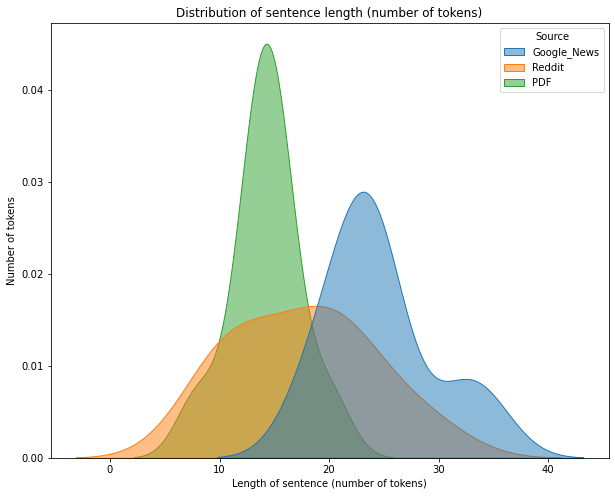

In [30]:
plt.figure(figsize=(10,8))

sns.kdeplot(data=df_raw, x='median_sent_len', hue='Source', alpha = 0.5, fill = True)
plt.xlabel('Length of sentence (number of tokens)')
plt.ylabel('Number of tokens')
plt.title('Distribution of sentence length (number of tokens)')

### POS tagging

Randomly select 3 sentences from each dataset, and apply POS tagging. Discuss the POS tagging results. Are the results as expected? Can the POS tagger well handle the domain specific terms?

In [31]:
# Randomly sample from each dataset
pos_dic = {'text' : [] , 
           'doc_no': [], 
           'sent_no': []}

random.seed(111)
source_cat = list(df_raw.Source.unique())

for cat in source_cat:
    data_1 = df_raw.loc[df_raw.Source == cat].reset_index(drop = True)
    
    max_article_count = data_1.shape[0] # get max no. doc for category
    rand_doc_no_ls = [random.randint(0, max_article_count-1) for _ in range(3)] 
    
    for rand_doc_no in rand_doc_no_ls:
        data = data_1.loc[rand_doc_no, 'sentence_tokens']

        max_doc_sentence = len(data) # max sentence for doc
        rand_sent_no = random.randint(0, max_doc_sentence-1) # Which sentence

        text = data[rand_sent_no]
        
        pos_dic['text'].append(text)
        pos_dic['doc_no'].append(rand_doc_no)
        pos_dic['sent_no'].append(rand_sent_no)
        
        print(cat)
        print(f'rand_doc: {rand_doc_no}')
        print(f'rand_sen: {rand_sent_no}')
        print(text)
        print('==========')

Google_News
rand_doc: 3
rand_sen: 6
Israel says around 1,500 Hamas fighters were killed in clashes before its army regained control of the area under attack.
Google_News
rand_doc: 5
rand_sen: 6
The police on Saturday said they were "aware of a social media post showing a man holding onto a sign relating to the Israel-Hamas conflict outside the Speakers’ Corner, and investigations are ongoing".
Google_News
rand_doc: 7
rand_sen: 13
Supporting oppressed people is human.
Reddit
rand_doc: 9
rand_sen: 2
Best time of the year to like League.
Reddit
rand_doc: 2
rand_sen: 26
At his request, BDS Coaching staff paid thousands of Euro to a pre-school teacher to give Sheo lessons about object permanence.
Reddit
rand_doc: 3
rand_sen: 17
We were given the key by the casters over and over again to decypher the message.
PDF
rand_doc: 3
rand_sen: 213
While the window attention method works
efficiently, it exhibits low accuracy due to random outputs when the input length exceeds the cache
size.
PDF
rand_

In [32]:
pos_df = pd.DataFrame(pos_dic)
pos_df['pos_tagging'] = pos_df.text.apply(lambda x: pos_tag(word_tokenize(x)))

In [33]:
print(pos_df.pos_tagging[1])

[('The', 'DT'), ('police', 'NN'), ('on', 'IN'), ('Saturday', 'NNP'), ('said', 'VBD'), ('they', 'PRP'), ('were', 'VBD'), ('``', '``'), ('aware', 'JJ'), ('of', 'IN'), ('a', 'DT'), ('social', 'JJ'), ('media', 'NNS'), ('post', 'NN'), ('showing', 'VBG'), ('a', 'DT'), ('man', 'NN'), ('holding', 'VBG'), ('onto', 'IN'), ('a', 'DT'), ('sign', 'NN'), ('relating', 'VBG'), ('to', 'TO'), ('the', 'DT'), ('Israel-Hamas', 'NNP'), ('conflict', 'NN'), ('outside', 'IN'), ('the', 'DT'), ('Speakers', 'NNP'), ('’', 'NNP'), ('Corner', 'NNP'), (',', ','), ('and', 'CC'), ('investigations', 'NNS'), ('are', 'VBP'), ('ongoing', 'VBG'), ("''", "''"), ('.', '.')]


In [34]:
for i in range(pos_df.shape[0]):
    print(pos_df.pos_tagging[i])
    print('===============')

[('Israel', 'NNP'), ('says', 'VBZ'), ('around', 'IN'), ('1,500', 'CD'), ('Hamas', 'NNP'), ('fighters', 'NNS'), ('were', 'VBD'), ('killed', 'VBN'), ('in', 'IN'), ('clashes', 'NNS'), ('before', 'IN'), ('its', 'PRP$'), ('army', 'NN'), ('regained', 'VBD'), ('control', 'NN'), ('of', 'IN'), ('the', 'DT'), ('area', 'NN'), ('under', 'IN'), ('attack', 'NN'), ('.', '.')]
[('The', 'DT'), ('police', 'NN'), ('on', 'IN'), ('Saturday', 'NNP'), ('said', 'VBD'), ('they', 'PRP'), ('were', 'VBD'), ('``', '``'), ('aware', 'JJ'), ('of', 'IN'), ('a', 'DT'), ('social', 'JJ'), ('media', 'NNS'), ('post', 'NN'), ('showing', 'VBG'), ('a', 'DT'), ('man', 'NN'), ('holding', 'VBG'), ('onto', 'IN'), ('a', 'DT'), ('sign', 'NN'), ('relating', 'VBG'), ('to', 'TO'), ('the', 'DT'), ('Israel-Hamas', 'NNP'), ('conflict', 'NN'), ('outside', 'IN'), ('the', 'DT'), ('Speakers', 'NNP'), ('’', 'NNP'), ('Corner', 'NNP'), (',', ','), ('and', 'CC'), ('investigations', 'NNS'), ('are', 'VBP'), ('ongoing', 'VBG'), ("''", "''"), ('.', 

In [42]:
# pos_df.to_csv('POS_Tagging.csv')